# Introduction

(NOTE: This notebook is intended for use with the slides found [here](https://github.com/cropsinsilico/CiS2021-hackathon/blob/main/slides.pdf)).

This is a Jupyter notebook. It allows us to run code (in this case Python) alongside text in different "cells". This cell is a markdown cell that can display text and html, the next cell is a code cell.

In the code cells (prefixed by `In [ ]:`), you can assign variables, perform calculations or call external functions/classes. You can run code cells by selecting the cell (so that a blue or green box appears around it) and then clicking the run button (located at the top of the page) or pressing `Shift+Enter` together. Then a number will appear inside the brackets indicating the order of when the cell was executed. 

Output from the cell will be displayed below it with the `Out[#]:` prefix where the number in the brackets indicates the input cell that generated it.

In [ ]:
x = 1
y = 3
z = (x + y)**3
z

Any Python code can be used, and we can import external packages as well just like in Python scripts. Cells can also use any variables created in any previously executed cell. The cell below imports some tools that will be used in the rest of this notebook.

In [1]:
from yggdrasil import tools  # Tools for displaying syntax highlighted source code in the notebook
from yggdrasil.runner import run  # Tool for running integrations from the notebook

The notebook can also display plots, 3D graphics, and interactive widgets. 

The cell below imports a package `trimesh` for loading and displaying 3D meshes in the notebook. You can drag the image to rotate the object and zoom in/out by scrolling over the image. This type of display will be used in some the examples today to display output.

In [2]:
import trimesh
fname = 'meshes/plants-2.obj'
mesh = trimesh.load_mesh(fname)
mesh.show()

# Integrating Models as Functions

yggdrasil provides interfaces in several languages that can be used to open connections with other models, but in many cases, making a model work in integrations can be done by allowing yggdrasil to wrap a function that executes the model calculations.

For example, the model displayed by the cell below calculates (albeit poorly) the intensity of light for a given day of the year and height from the ground. It is written as a Python function that takes `doy` (day of the year) and `height` as inputs and returns the intensity as output.

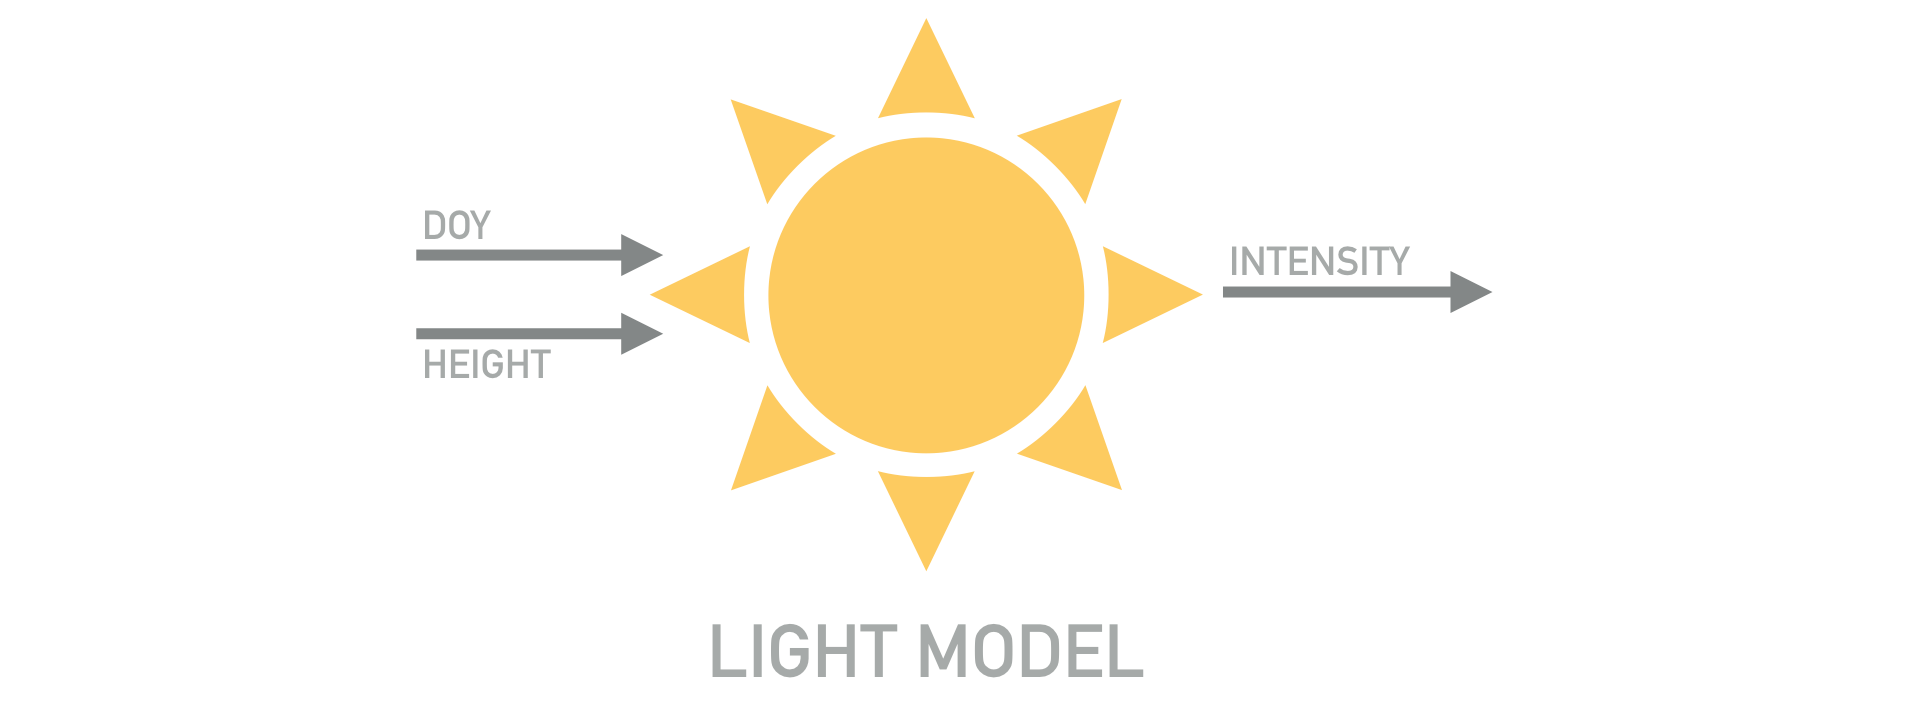

In [ ]:
tools.display_source('models/light_v0.py', number_lines=True)

To use this model with yggdrasil, no modification of the code is necessary. The only new material required is a YAML configuration file. The cell below displays the YAML for the model above.

In [16]:
tools.display_source('yamls/light_v0_python.yml', number_lines=True)

file: yamls/light_v0_python.yml
 1: model:
 2:   name: light
 3:   language: python
 4:   args: ../models/light_v0.py
 5:   function: light



This alone will not allow yggdrasil to run as the model inputs & output are not connected to anything. The YAML file below declares the connections that should be made to get input from the tab-delimited table `input/light_v0.txt` (also shown below) and direct output to the file `output/light_v0.txt`.

Since the input/output to the light model is not explicitly defined in the model YAML above, yggdrasil assumes that all inputs will come from the same channel named `<model_name>:input` and names the output channel `<model_name>:output`.

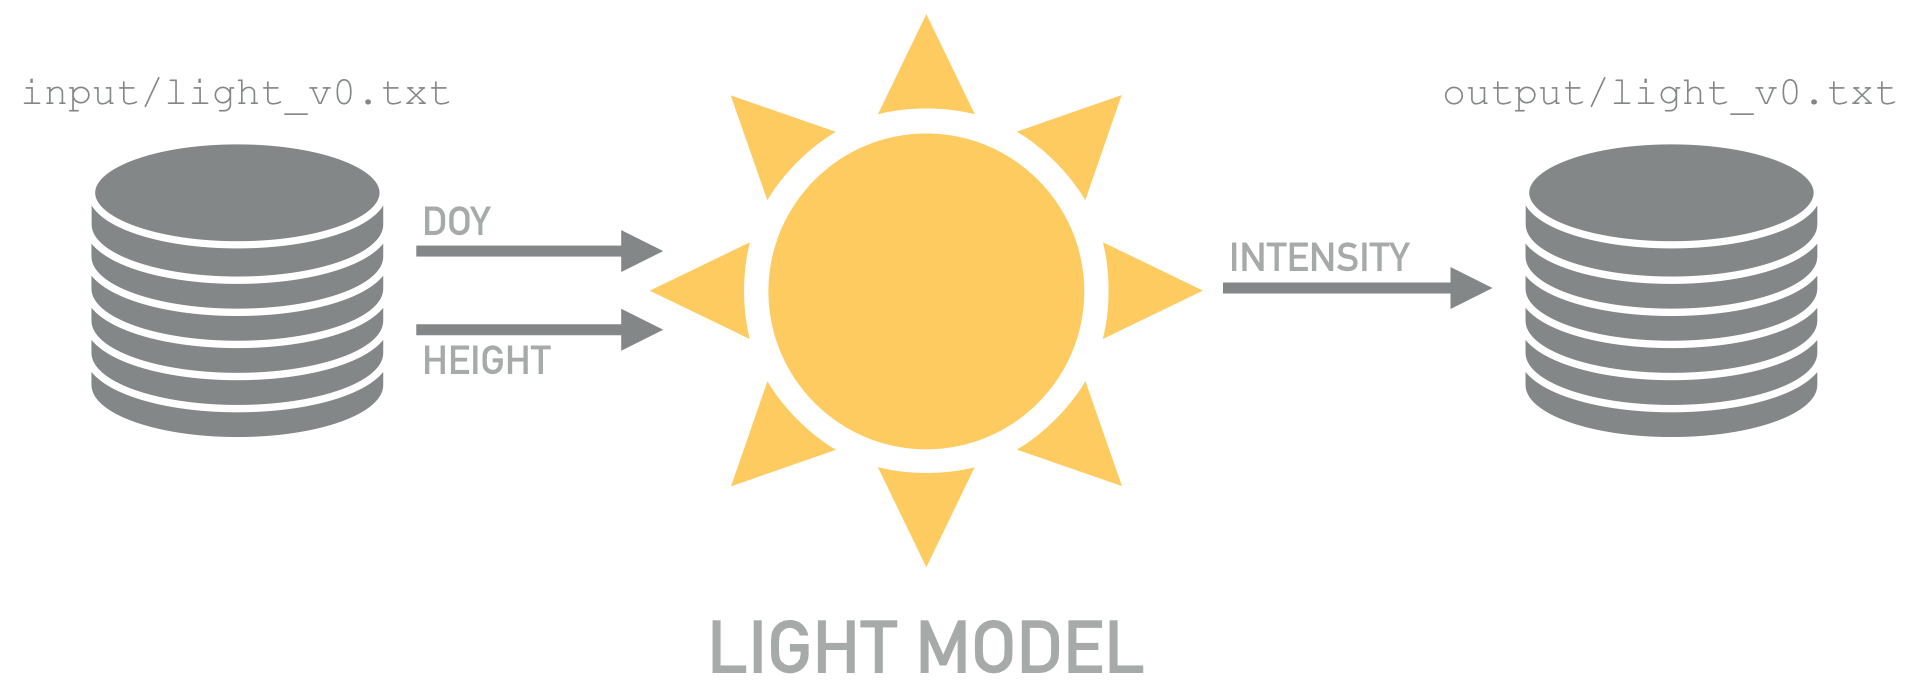

In [17]:
tools.display_source('yamls/connections_v0.yml', number_lines=True)

file: yamls/connections_v0.yml
 1: connections:
 2:   - input:
 3:       name: ../input/light_v0.txt
 4:       filetype: table
 5:     output: light:input
 6:   - input: light:output
 7:     output:
 8:       name: ../output/light_v0.txt
 9:       filetype: table
10:       field_names: [intensity]



To run the light-to-file integration defined in these two YAML files, the `run` function is called with the paths to the YAML files as input. This is equivalent to calling `yggrun yamls/light_v0_python.yml yamls/connections_v0.yml --production-run` from the command line.

The output from the yggdrasil integration will include output from the models themselves, some information about what stage each model is in, and the duration of different stages in the integration take to complete. In the case of running multiple models, the output from different models will often be interwoven and does not necessary indicate the order that models are executed in.

In [ ]:
run(['yamls/light_v0_python.yml', 'yamls/connections_v0.yml'], production_run=True)

The cell below will display the contents of the output file `output/light_v0.txt` following the run.

In [ ]:
tools.display_source('output/light_v0.txt', number_lines=True)

## Command Line Interface
The examples above have been using yggdrasil's Python interface to run the integration, but that is not necessary. yggdrasil has a command line utility for running integration `yggrun` which takes YAML paths as inputs.

## The `production_run` Keyword
You may have noticed that we passed the `production_run` keyword to the `run` API function with a value of `True`. When set to `True`, yggdrasil turns of several safe guards that increase run-time. These include things like checking data formats and validating inputs/outputs to/from framework components. It is highly recommended, that `production_run` is only set to `True` when you are done testing an integration and are ready for a "production run" that requires higher performance. The `production_run` flag can also be passed to the command line interface `yggrun` as `--production-run`.

## Similarly in Other Languages

NOTE: Units must be explicitly added via a `datatype` entry in the model yaml for the compiled languages (i.e. C, C++, & Fortran)

### C++ Version

In [ ]:
tools.display_source('models/light_v0.cpp', number_lines=True)
tools.display_source('yamls/light_v0_cpp.yml', number_lines=True)
run(['yamls/light_v0_cpp.yml', 'yamls/connections_v0.yml'], production_run=True)
tools.display_source('output/light_v0.txt', number_lines=True)

### Fortran Version

In [ ]:
tools.display_source('models/light_v0.f90', number_lines=True)
tools.display_source('yamls/light_v0_fortran.yml', number_lines=True)
run(['yamls/light_v0_fortran.yml', 'yamls/connections_v0.yml'], production_run=True)
tools.display_source('output/light_v0.txt', number_lines=True)

### R Version

In [ ]:
tools.display_source('models/light_v0.R', number_lines=True)
tools.display_source('yamls/light_v0_R.yml', number_lines=True)
run(['yamls/light_v0_R.yml', 'yamls/connections_v0.yml'], production_run=True)
tools.display_source('output/light_v0.txt', number_lines=True)

# Integrating Models via Interface

The function wrapping method of yggdrasil works in many cases, but not all. When a model must send or receive data to/from another model mid-calculation or the model algorithm is written such that writing it as a function would be unwieldy, the yggdrasil interface can be used directly.

For example, the model below simulates growth of a 3D shoot structure over time and is executed via the command line with parameters controlling the how long the simulations runs and what the initial mesh looks like.

In [ ]:
tools.display_source('models/shoot_v0.py', number_lines=True)

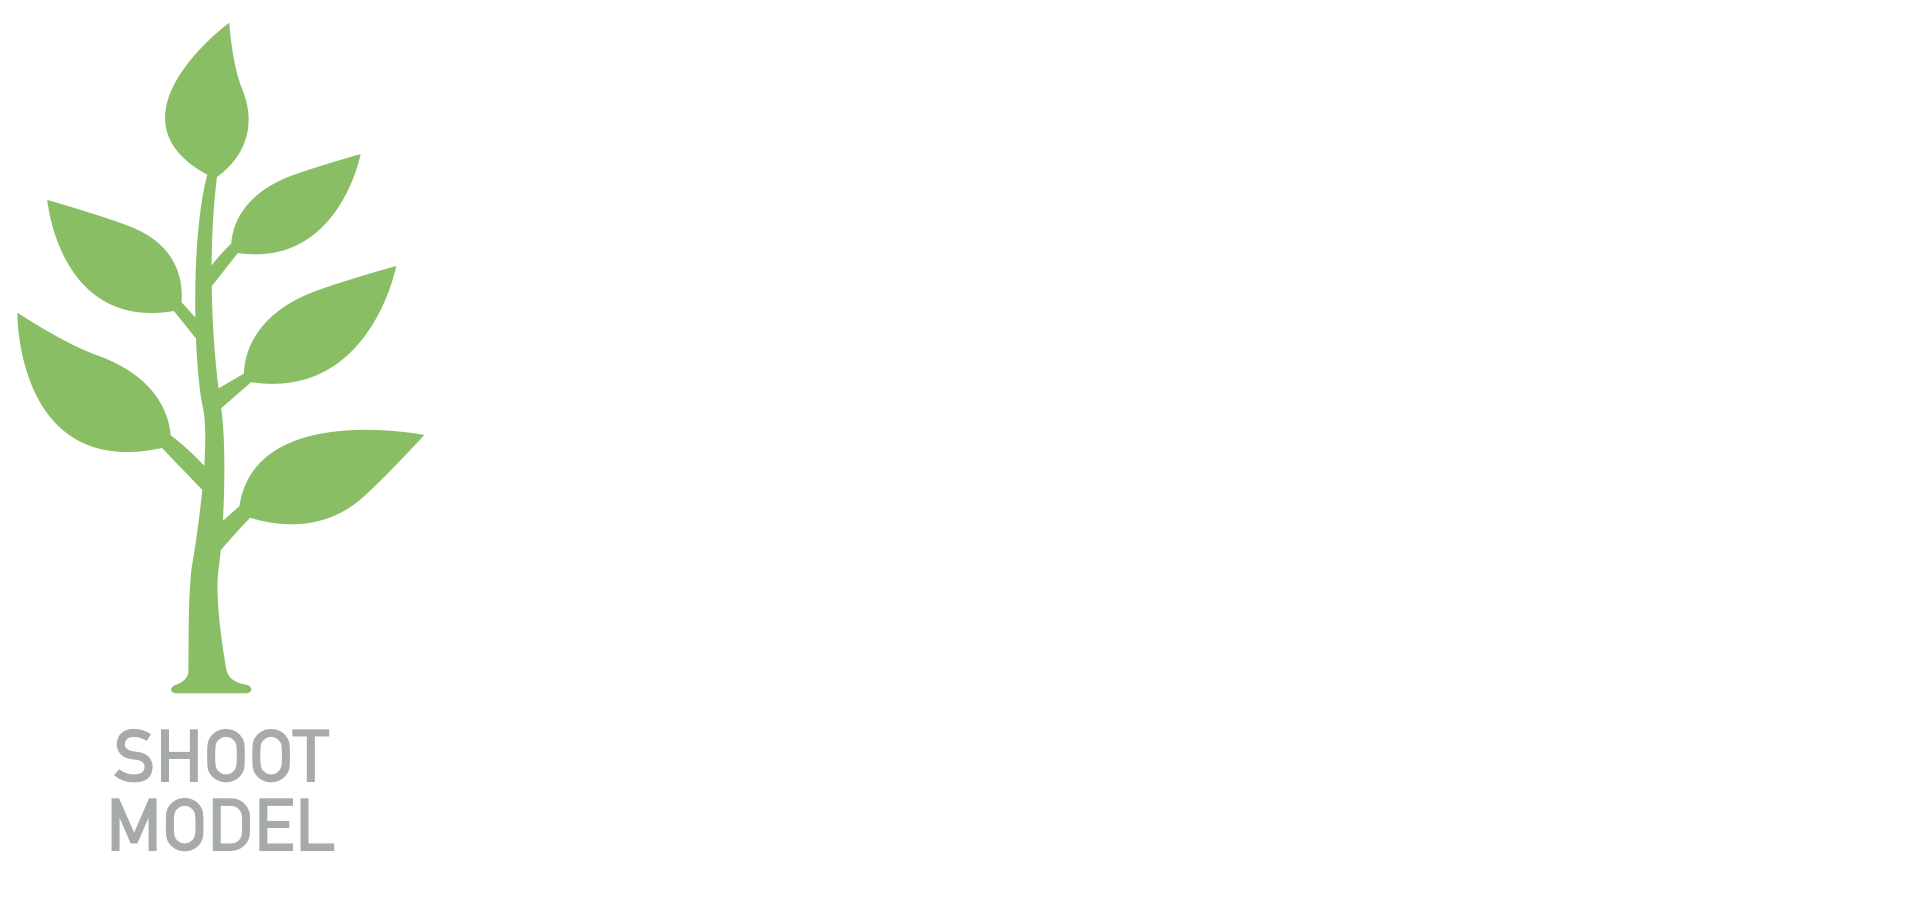

We can run this model via the command line or via yggdrasil using the YAML displayed below which runs the model for 48 hrs with a time step of 6 hrs and does not handle any input or output.

In [18]:
tools.display_source('yamls/shoot_v0.yml', number_lines=True)
run('yamls/shoot_v0.yml', production_run=True)

file: yamls/shoot_v0.yml
 1: model:
 2:   name: shoot
 3:   language: python
 4:   args: [../models/shoot_v0.py, 0.0, 48.0, 6.0]

INFO:49406:runner.startDrivers[499]:YggRunner(runner): Starting I/O drivers and models on system Meagans-MacBook-Air.local in namespace yggdrasil with rank 0
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/shoot_v0.py 0.0 48.0 6.0
INFO:49406:runner.waitModels[553]:YggRunner(runner): shoot finished running.
INFO:49406:runner.waitModels[559]:YggRunner(runner): shoot finished exiting.
INFO:49406:runner.waitModels[573]:YggRunner(runner): All models completed
INFO:49406:runner.run[374]:YggRunner(runner):                 init	0.000001
INFO:49406:runner.run[374]:YggRunner(runner):         load drivers	0.000985
INFO:49406:runner.run[374]:YggRunner(runner):        start drivers	0.022737
INFO:49406:runner.run[374]:YggRunner(runner):           run models	1.725096
INFO:49406:runner.run[374]:YggRunner(runn

The final mesh from this simulation is displayed by the cell below using the `trimesh` package.

In [ ]:
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

If we want to determine the light intensity at the top of the plant at each timestep, re-writing this model as a function and allowing yggdrasil to wrap it requres a lot of modification to the original code. Instead we can create an output channel via the yggdrasil Python interface with minimal modification to the code.

The cell below shows the diff for an updated version of this model that does this.
1. Checks if the yggdrasil version of the code should be run
1. Imports the relevant yggdrasil modules and functions and opens an output channel with the name `height`
1. Sends the time and maximum height of the mesh to the `height` output channel with units


In [22]:
tools.display_source_diff('models/shoot_v0.py', 'models/shoot_v1.py', number_lines=True)

file1: models/shoot_v0.py
file2: models/shoot_v1.py
 1:   import os
 2:   import trimesh
 3:   import argparse
 4:   
 5:   _dir = os.path.dirname(os.path.realpath(__file__))
 6:   
 7:   # Parse command-line arguments
 8:   parser = argparse.ArgumentParser("Simulate a shoot's growth over time.")
 9:   parser.add_argument('tmin', help='Starting time (in hours)', type=float)
10:   parser.add_argument('tmax', help='Ending time (in hours)', type=float)
11:   parser.add_argument('tstep', help='Time step (in hours)', type=float)
12:   parser.add_argument('--meshfile', help='Path to file where mesh is stored.',
13:                       default='../meshes/plants-2.obj')
14:   args = parser.parse_args()
15:   tmin = args.tmin
16:   tmax = args.tmax
17:   tstep = args.tstep
18:   mesh = trimesh.load_mesh(args.meshfile)
19:   
20:   # Set initial conditions
21:   mass = 2000.0
22:   t = tmin
23:   i = 0
24:   
25: + # Check if model is running as a part of an yggdrasil integration
26: + with_yg

The above model can be run in the exact same manner as the original without yggdrasil. The YAML diff displayed in the cell below shows the changes necessary to connect the `height` output to a table file `output/height.txt` in the absence of any other connection.

In [19]:
tools.display_source_diff('yamls/shoot_v0.yml', 'yamls/shoot_v1.yml', number_lines=True)

file1: yamls/shoot_v0.yml
file2: yamls/shoot_v1.yml
 1:   model:
 2:     name: shoot
 3:     language: python
    -   args: [../models/shoot_v0.py, 0.0, 48.0, 6.0]
    ?                                                          ^

 4: +   args: [../models/shoot_v1.py, 0.0, 48.0, 6.0]
    ?                                                          ^

 5: +   outputs:
 6: +     - name: height
 7: +       default_file:
 8: +         name: ../output/height.txt
 9: +         filetype: table



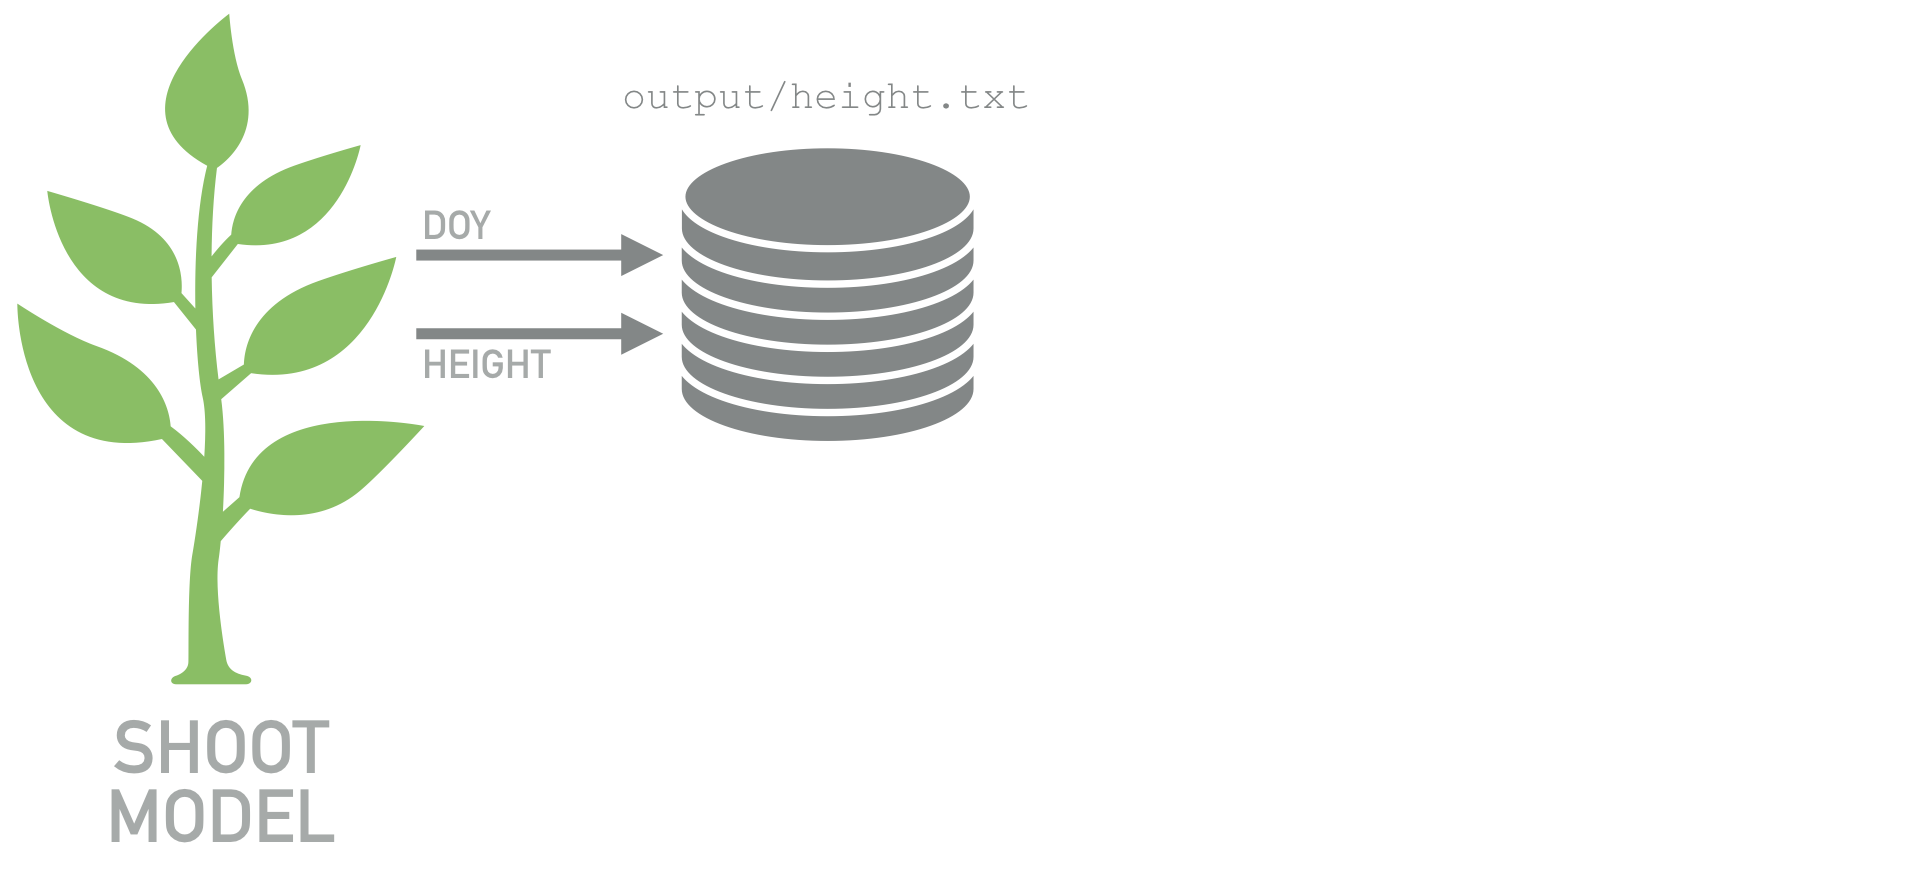

The cell below runs the 1-model integration defined in the YAML above.

In [21]:
run(['yamls/shoot_v1.yml'], production_run=True)

INFO:49406:runner.startDrivers[499]:YggRunner(runner): Starting I/O drivers and models on system Meagans-MacBook-Air.local in namespace yggdrasil with rank 0
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/shoot_v1.py 0.0 48.0 6.0
INFO:49406:runner.waitModels[553]:YggRunner(runner): shoot finished running.
INFO:49406:runner.waitModels[559]:YggRunner(runner): shoot finished exiting.
INFO:49406:runner.waitModels[573]:YggRunner(runner): All models completed
INFO:49406:runner.run[374]:YggRunner(runner):                 init	0.000001
INFO:49406:runner.run[374]:YggRunner(runner):         load drivers	0.012504
INFO:49406:runner.run[374]:YggRunner(runner):        start drivers	0.063354
INFO:49406:runner.run[374]:YggRunner(runner):           run models	7.868019
INFO:49406:runner.run[374]:YggRunner(runner):              at exit	0.007762
INFO:49406:runner.run[376]:YggRunner(runner): ========================================
INFO:494

The resulting mesh and `output/height.txt` file is displayed by the next two cells.

In [ ]:
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

In [23]:
tools.display_source('output/height.txt')

file: output/height.txt
# hr	m
# %g	%g
0	77.2603
6	80.6941
12	84.4399
18	88.5415
24	93.0513
30	98.0321
36	103.561
42	109.73
48	116.656


